In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add 'FTLE3D' folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE3D")

Wall time: 0 ns


# Overview

In the following notebook we compute the finite time Lyapunov exponent (FTLE) on the three-dimensional, unsteady ABC-flow. The notebook is structured as follows:

1. Import data from the file 'ABC.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. FTLE:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid.
    <br />
    
    * Compute FTLE from maximum singular value $ \sigma_{max} $ of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ according to:
    \begin{equation}
    \mathrm{FTLE}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0}\log(\sigma_{max}(\mathbf{x}_0))
    \end{equation}

# Computational parameters and analytic velocity field

Here we define the computational parameters and the analytic velocity field.

In [2]:
# import numpy
import numpy as np

# import math tools
from math import sqrt, pi

# number of cores to be used for parallel computing
Ncores = 4

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_z = True
periodic = [periodic_x, periodic_y, periodic_z]

def velocity(x, y, z):

    u = sqrt(3)*np.sin(z)+np.cos(y)
    v = sqrt(2)*np.sin(x)+sqrt(3)*np.cos(z)
    w = np.sin(y)+sqrt(2)*np.cos(x)
    
    return np.array([u, v, w])

def grad_velocity(x, y, z, A=1, B=np.sqrt(2/3), C=1/np.sqrt(3)):
    
    grad_vel = np.zeros((x.shape[0], 3, 3))

    dudx = 0
    dudy = -np.sin(y)
    dudz = sqrt(3)*np.cos(z)
    
    dvdx = sqrt(2)*np.cos(x)
    dvdy = 0
    dvdz = -sqrt(3)*np.sin(z)
    
    dwdx = -sqrt(2)*np.sin(x)
    dwdy = np.cos(y)
    dwdz = 0
    
    grad_vel[:,0,0] = dudx
    grad_vel[:,1,0] = dvdx
    grad_vel[:,2,0] = dwdx
    
    grad_vel[:,0,1] = dudy
    grad_vel[:,1,1] = dvdy
    grad_vel[:,2,1] = dwdy
    
    grad_vel[:,0,2] = dudz
    grad_vel[:,1,2] = dvdz
    grad_vel[:,2,2] = dwdz
    
    return grad_vel

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [3]:
%%time
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 10 # float

# Time step-size (in days)
dt = 0.025 # float

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 200 # int
Nx = 200 # int
Nz = 200 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]
dz = z_domain[1]-z_domain[0]

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int
Nz = X_domain.shape[2] # int

Wall time: 24.9 ms


# Define Integration

In [4]:
from tqdm.notebook import tqdm

def integration_dFdt(time, x, periodic):
    
    # reshape x
    x = x.reshape(3, -1)
    
    # Initialize arrays for flow map and derivative of flow map
    Fmap = np.zeros((len(time), 3, x.shape[1]))
    dFdt = np.zeros((len(time)-1, 3, x.shape[1]))
    
    # Step-size
    dt = time[1]-time[0]
    
    counter = 0

    # initial conditions
    Fmap[counter,:,:] = x
    
    # Runge Kutta 4th order integration with fixed step size dt
    for t in tqdm(time[:-1]):
        
        Fmap[counter+1,:, :], dFdt[counter,:,:] = RK4_step(t, Fmap[counter,:, :], dt)
    
        counter += 1
    
    return Fmap, dFdt

def integration_dDF_dt(time, x, periodic):
    
    # reshape x
    x = x.reshape(3, -1)
    
    # Initialize arrays for flow map and derivative of flow map
    Fmap = np.zeros((len(time), 3, x.shape[1]))
    dFdt = np.zeros((len(time)-1, 3, x.shape[1]))
    DF = np.zeros((len(time), 3, 3, x.shape[1]))
    
    # Step-size
    dt = time[1]-time[0]
    
    counter = 0

    # initial conditions
    Fmap[counter,:,:] = x
    DF[counter,0,0,:] = 1
    DF[counter,1,1,:] = 1
    DF[counter,2,2,:] = 1
    
    # Runge Kutta 4th order integration with fixed step size dt
    for t in tqdm(time[:-1]):
        
        Fmap[counter+1,:, :], dFdt[counter,:,:], DF[counter+1,:,:,:] = RK4_step(t, Fmap[counter,:, :], DF[counter, :,:,:], dt)
    
        counter += 1
    
    return Fmap, dFdt, DF

def RK4_step(t, x1, DF1, dt):
    
    t0 = t
    
    # Compute x_prime at the beginning of the time-step by re-orienting and rescaling the vector field
    x_prime = velocity(x1[0,:], x1[1,:], x1[2,:])
    
    # compute gradient of velocity
    grad_k1 = DF1.copy()
    
    grad_vel = grad_velocity(x1[0,:], x1[1,:], x1[2,:])
    
    for i in range(grad_k1.shape[2]):
        grad_k1[:,:,i] = dt*np.dot(grad_vel[i,:,:], DF1[:,:,i])
    
    # compute derivative
    k1 = dt * x_prime
    
    # Update position at the first midpoint.
    x2 = x1 + .5 * k1
    
    DF2 = DF1 + .5 * grad_k1
     
    # Update time
    t = t0 + .5*dt
    
    # Compute x_prime at the first midpoint.
    x_prime = velocity(x2[0,:], x2[1,:], x2[2,:])
    
    # compute gradient of velocity
    grad_k2 = DF1.copy()
    
    grad_vel = grad_velocity(x2[0,:], x2[1,:], x2[2,:])
    
    for i in range(grad_k2.shape[2]):
        grad_k2[:,:,i] = dt*np.dot(grad_vel[i,:,:], DF2[:,:,i])
    
    # compute derivative
    k2 = dt * x_prime

    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    DF3 = DF1 + .5 * grad_k2
    
    # Update time
    t = t0 + .5*dt
    
    # Compute x_prime at the second midpoint.
    x_prime = velocity(x3[0,:], x3[1,:], x3[2,:])
    
    # compute gradient of velocity
    grad_k3 = DF3.copy()
    
    grad_vel = grad_velocity(x3[0,:], x3[1,:], x3[2,:])
    
    for i in range(grad_k3.shape[2]):
        grad_k3[:,:,i] = dt*np.dot(grad_vel[i,:,:], DF3[:,:,i])
    
    # compute derivative
    k3 = dt * x_prime
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    DF4 = DF1 + grad_k3
    
    # Update time
    t = t0+dt
    
    # Compute derivative at the end of the time-step.
    x_prime = velocity(x4[0,:], x4[1,:], x4[2,:]) 
    
    # compute gradient of velocity
    grad_k4 = DF4.copy()
    
    grad_vel = grad_velocity(x4[0,:], x4[1,:], x4[2,:])
    
    for i in range(grad_k4.shape[2]):
        grad_k4[:,:,i] = dt*np.dot(grad_vel[i,:,:], DF4[:,:,i])
    
    # compute derivative
    k4 = dt * x_prime
    
    # Compute RK4 derivative
    y_prime_update = 1.0 / 6.0*(k1 + 2 * k2 + 2 * k3 + k4)
    
    dDFdt_update = 1.0 / 6.0*(grad_k1 + 2 * grad_k2 + 2 * grad_k3 + grad_k4)
    
    # Integration y <-- y + y_primeupdate
    y_update = x1 + y_prime_update

    # Integration DF <-- DF + dDFdt_update
    DF_update = DF1 + dDFdt_update
    
    return y_update, y_prime_update/dt, DF_update

# Gradient of flow map

In [5]:
from numba import njit, prange

def gradient_flowmap(time, x, periodic, aux_grid):
    
    # define auxiliary grid spacing
    rho_x = aux_grid[0]
    rho_y = aux_grid[1]
    rho_z = aux_grid[2]
    
    XL, XR, XU, XD, XF, XB = [], [], [], [], [], []
    
    for i in range(x.shape[1]):
        
        xr = x[0, i] + rho_x # float
        xl = x[0, i] - rho_x # float
        yu = x[1, i] + rho_y # float
        yd = x[1, i] - rho_y # float
        zF = x[2, i] + rho_z # float
        zB = x[2, i] - rho_z # float
    
        XL.append([xl, x[1, i], x[2, i]])
        XR.append([xr, x[1, i], x[2, i]])
        XU.append([x[0, i], yu, x[2, i]])
        XD.append([x[0, i], yd, x[2, i]])
        XF.append([x[0, i], x[1, i], zF])
        XB.append([x[0, i], x[1, i], zB])
    
    XL = np.array(XL).transpose()
    XR = np.array(XR).transpose()
    XU = np.array(XU).transpose()
    XD = np.array(XD).transpose()
    XF = np.array(XF).transpose()
    XB = np.array(XB).transpose()
    
    # launch trajectories from auxiliary grid
    XLend = integration_dFdt(time, XL, periodic)[0] # array (Nt, 3)
    XRend = integration_dFdt(time, XR, periodic)[0] # array (Nt, 3)
    XDend = integration_dFdt(time, XD, periodic)[0] # array (Nt, 3)
    XUend = integration_dFdt(time, XU, periodic)[0] # array (Nt, 3)
    XFend = integration_dFdt(time, XF, periodic)[0] # array (Nt, 3)
    XBend = integration_dFdt(time, XB, periodic)[0] # array (Nt, 3)
        
    return iterate_gradient(XRend, XLend, XUend, XDend, XFend, XBend, rho_x, rho_y, rho_z)

@njit(parallel = True)
def iterate_gradient(XRend, XLend, XUend, XDend, XFend, XBend, rho_x, rho_y, rho_z):
    
    gradFmap = np.zeros((XLend.shape[0], 3, 3, XLend.shape[2])) # array (Nt, 3, 3, Nx*Ny)
    
    for i in prange(XLend.shape[2]):      
            
        for j in prange(XLend.shape[0]):

            gradFmap[j,0,0,i] = (XRend[j,0,i]-XLend[j,0,i])/(XRend[0,0,i]-XLend[0,0,i])
            gradFmap[j,1,0,i] = (XRend[j,1,i]-XLend[j,1,i])/(XRend[0,0,i]-XLend[0,0,i])
            gradFmap[j,2,0,i] = (XRend[j,2,i]-XLend[j,2,i])/(XRend[0,0,i]-XLend[0,0,i])
        
            gradFmap[j,0,1,i] = (XUend[j,0,i]-XDend[j,0,i])/(XUend[0,1,i]-XDend[0,1,i])
            gradFmap[j,1,1,i] = (XUend[j,1,i]-XDend[j,1,i])/(XUend[0,1,i]-XDend[0,1,i])
            gradFmap[j,2,1,i] = (XUend[j,2,i]-XDend[j,2,i])/(XUend[0,1,i]-XDend[0,1,i])
                
            gradFmap[j,0,2,i] = (XFend[j,0,i]-XBend[j,0,i])/(XFend[0,2,i]-XBend[0,2,i])
            gradFmap[j,1,2,i] = (XFend[j,1,i]-XBend[j,1,i])/(XFend[0,2,i]-XBend[0,2,i])
            gradFmap[j,2,2,i] = (XFend[j,2,i]-XBend[j,2,i])/(XFend[0,2,i]-XBend[0,2,i])
    
    return gradFmap

# FTLE

Next, we compute the FTLE over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. From the maximum singular value of the gradient of the flow map we can then compute the FTLE.

In [6]:
%%time

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .01 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy, aux_grid_ratio*dz] # list (3, )

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0 = X_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)
y0 = Y_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)
z0 = Z_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)

# Initial conditions
X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)

# Compute gradient of flow map
#gradFmap = gradient_flowmap(time, X0, periodic, aux_grid)

gradFmap = integration_dDF_dt(time, X0, periodic)[-1]

# Extract gradient from t0 to tN
gradFmap_t0_tN = gradFmap[-1,:, :, :] # array (Nt, 3, 3, Nx*Ny)
    
# Compute FTLE
FTLE = [] # list (Nx*Ny*Nz,)
for i in range(gradFmap_t0_tN.shape[2]):
    FTLE.append(_FTLE(gradFmap_t0_tN[:,:,i], lenT))

  0%|          | 0/400 [00:00<?, ?it/s]

Wall time: 5min 2s


In [7]:
# Reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((Ny, Nx)) # array (Ny, Nx, Nz)
Y0_gridded = y0.reshape((Ny, Nx)) # array (Ny, Nx, Nz)
Z0_gridded = z0.reshape((Ny, Nx)) # array (Ny, Nx, Nz)
FTLE = np.array(FTLE).reshape((Ny, Nx)) # array (Ny, Nx, Nz)

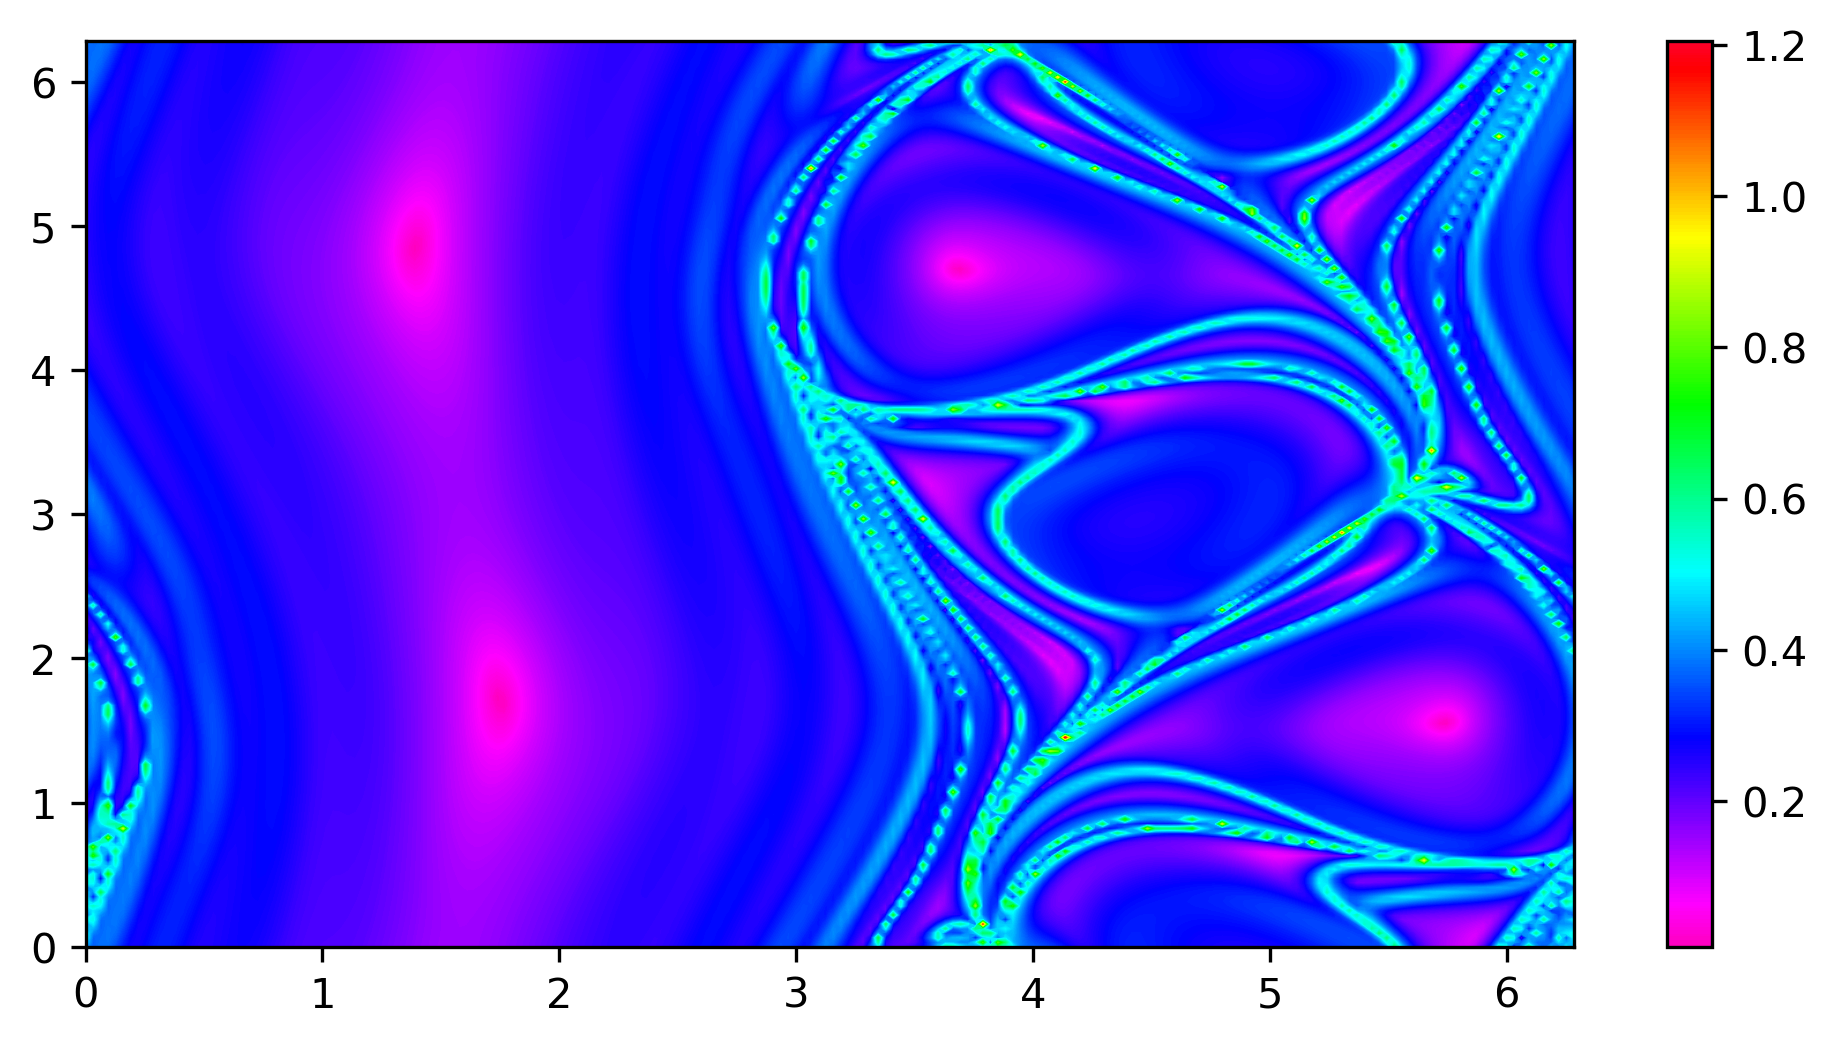

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 4), dpi = 300)
ax = plt.axes()
cax = ax.contourf(X0_gridded, Y0_gridded, FTLE, levels = 500, cmap = "gist_rainbow_r")
plt.colorbar(cax, ticks = np.arange(0, 3, 0.2))
plt.show()